<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/LaplacianMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 800*800 Laplacian Matrix from Meso-Fields

* Calculate the Laplacian matrix of the square matrix.
* Calculate the eigenvalues and eigenvectors of the Laplacian matrix.
* Sort the eigenvalues in ascending order.
* The second smallest eigenvalue corresponds to the second eigenvector.
* Normalize the second eigenvector to have a unit length.

In [53]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [54]:
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import torch
import nltk
import io
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.colab import files
import humanize
!pip install 'networkx<2.7'
!pip install 'scipy>=1.8'
#!pip install google-sheets-to-csv
# enable data table format
from google.colab import data_table
data_table.enable_dataframe_formatter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive/')

Mounted at /content/drive/


In [55]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '17RXABV5bp0-u_oSvKmKONW3f7FLzrjYl'
print (id) # Verify that you have everything
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('MesoFieldsMatrix.csv')  
edgelist = pd.read_csv('MesoFieldsMatrix.csv', sep=";") # Dataset is now stored in a Pandas Dataframe
edgelist.head(1)
print(edgelist.dtypes)

17RXABV5bp0-u_oSvKmKONW3f7FLzrjYl
source    int64
target    int64
weight    int64
dtype: object


In [5]:
# concatenate the source and target columns to create a node list
nodelist = pd.concat([edgelist['source'], edgelist['target']]).unique()

# print the node list
print("Node list: ", nodelist[0:10])

Node list:  [0 1 2 3 4 5 6 7 8 9]


In [6]:
from networkx.linalg.graphmatrix import adjacency_matrix
import pandas as pd
import numpy as np
import networkx as nx

G=nx.from_pandas_edgelist(edgelist,'source','target','weight')

In [7]:
Degrees = nx.degree(G, weight='weight')
print(Degrees[0])

944790


In [ ]:
# Get the degree of each node in the graph
degrees = dict(G.degree(weight='weight'))

# Convert the degree dictionary to a NumPy array
degrees_array = np.array(list(degrees.values()))

# Print the degrees array
print(degrees_array)

In [9]:
# Compute the Laplacian matrix
# The graph Laplacian is the matrix L = D - A, where A is the adjacency matrix and D is the diagonal matrix of node degrees.
laplacian_matrix = nx.laplacian_matrix(G, nodelist = nodelist, weight='weight').astype(float)

# print the shape of the Laplacian matrix
print("Laplacian matrix shape: ", laplacian_matrix.shape)

# Convert the Laplacian matrix to a dense numpy array and inspect
laplacian_matrix_array = laplacian_matrix.toarray()
df = pd.DataFrame(laplacian_matrix_array, columns=G.nodes(), index=G.nodes())
print(df.head(5))

Laplacian matrix shape:  (865, 865)
        0          1         2         3          4       5       6    \
0  944790.0    -3990.0      -2.0     -75.0       -6.0   -28.0   -14.0   
1   -3990.0  1517891.0     -19.0     -86.0     -104.0   -79.0 -4067.0   
2      -2.0      -19.0  363783.0   -5065.0     -225.0  -325.0  -807.0   
3     -75.0      -86.0   -5065.0  539938.0     -526.0  -352.0  -782.0   
4      -6.0     -104.0    -225.0    -526.0  2062685.0 -2063.0  -354.0   

       7        8      9    ...    841   846  857     840   810    811   842  \
0     -3.0    -87.0 -127.0  ...   -4.0  -4.0  0.0     0.0   0.0   -1.0  -2.0   
1   -856.0  -3839.0  -44.0  ... -114.0 -51.0 -4.0   -79.0  -4.0    0.0 -12.0   
2  -2164.0    -95.0  -23.0  ...  -60.0  -3.0 -1.0 -1469.0 -25.0  -16.0  -1.0   
3  -5164.0   -300.0 -251.0  ...  -23.0  -3.0 -3.0   -32.0 -60.0 -116.0  -5.0   
4 -13158.0 -15833.0  -61.0  ...  -18.0  -4.0 -8.0   -88.0 -30.0    0.0 -16.0   

   843    830     844  
0  0.0   -7.0  -526.

In [ ]:
ones = np.ones(865)
#print(ones)

laplacian_matrix * ones

In [ ]:
import scipy.sparse.linalg

# compute all the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix.toarray())

# print the Laplacian eigenvalues
print("Laplacian eigenvalues: ", eigenvalues)
print("Laplacian eigenvectors: ", eigenvectors)

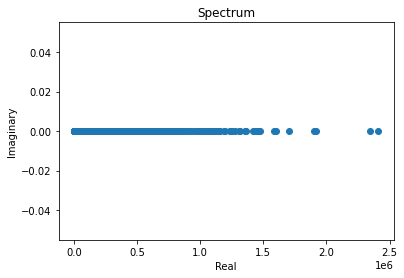

In [12]:
# Plot the eigenvalues
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues))
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Spectrum")
plt.show()

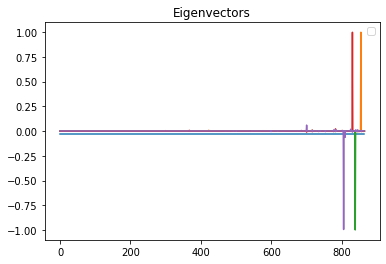

In [13]:
# Plot the first three eigenvectors
for i in range(5):
    plt.plot(eigenvectors[:, i])
plt.legend()
plt.title("Eigenvectors")
plt.show()

In [14]:
print("Number of eigenvectors:", eigenvectors.shape[1])

Number of eigenvectors: 865


Text(0, 0.5, 'third_eigenvector')

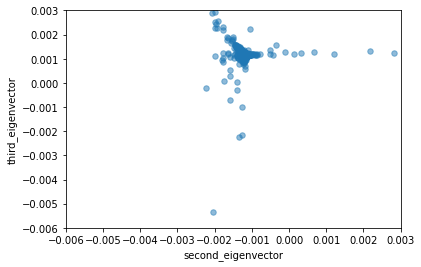

In [15]:
v1 = eigenvectors[:, 0]
v2 = eigenvectors[:, 1]
v3 = eigenvectors[:, 2]

# make a scatterplot of the second and the third eigenvectors
# Set custom axis ranges
plt.xlim(-0.006, 0.003)
plt.ylim(-0.006, 0.003)

plt.scatter(v2, v3, s=30, alpha = 0.5)
plt.xlabel('second_eigenvector')
plt.ylabel('third_eigenvector')

In [29]:
# Extract the second eigenvector and corresponding eigenvalue
second_eigenvalue = eigenvalues[1]
second_eigenvector = eigenvectors[:, 1]

# Sort the second eigenvector in ascending order
sort_index = np.argsort(second_eigenvector)
second_eigenvector = second_eigenvector[sort_index]

# Keep track of the original indices of the Laplacian Matrix
original_indices = np.arange(len(second_eigenvector))[sort_index]

print("Second Eigenvalue:", second_eigenvalue)
print("Sorted Second Eigenvector:", second_eigenvector)
print("Original Indices:", original_indices)

Second Eigenvalue: 656651.9573541512
Sorted Second Eigenvector: [-6.57980786e-01 -2.48531408e-01 -1.91059004e-01 -1.43002412e-01
 -1.28982338e-01 -8.98542419e-02 -8.66583191e-02 -8.35526248e-02
 -8.32388671e-02 -7.96790037e-02 -7.45439728e-02 -6.85870531e-02
 -6.81803027e-02 -6.05573681e-02 -5.77254902e-02 -5.75934511e-02
 -5.41339786e-02 -5.24995898e-02 -4.70039387e-02 -4.27671665e-02
 -4.21666140e-02 -4.13535965e-02 -3.93106000e-02 -3.93075302e-02
 -3.69415528e-02 -3.12763251e-02 -2.92505045e-02 -2.76982875e-02
 -2.73412379e-02 -2.47068787e-02 -2.42473328e-02 -2.07580530e-02
 -2.02597365e-02 -1.95468166e-02 -1.95087203e-02 -1.94565787e-02
 -1.94021260e-02 -1.93307439e-02 -1.86469524e-02 -1.79170399e-02
 -1.65718304e-02 -1.65037587e-02 -1.50904900e-02 -1.47902409e-02
 -1.46863059e-02 -1.44996432e-02 -1.35729534e-02 -1.29795460e-02
 -1.26620048e-02 -1.22108637e-02 -1.20016969e-02 -1.18330474e-02
 -1.12056060e-02 -1.10646642e-02 -1.09173615e-02 -1.05499085e-02
 -9.77901978e-03 -9.702751

In [51]:
# Create a pandas DataFrame with two columns
data = {'second_eigenvector': second_eigenvector, 'original_indices': original_indices}
df = pd.DataFrame(data)

df['cluster2'] = (df.index // 2).astype(int)
df['cluster3'] = (df.index // 3).astype(int)
df['cluster4'] = (df.index // 4).astype(int)
df['cluster5'] = (df.index // 5).astype(int)
df['cluster10'] = (df.index // 10).astype(int)
print(df)

     second_eigenvector  original_indices  cluster2  cluster3  cluster4  \
0             -0.657981               128         0         0         0   
1             -0.248531                65         0         0         0   
2             -0.191059               137         1         0         0   
3             -0.143002                82         1         1         0   
4             -0.128982               285         2         1         1   
..                  ...               ...       ...       ...       ...   
860            0.138528               393       430       286       215   
861            0.152481                25       430       287       215   
862            0.186824               163       431       287       215   
863            0.215348               112       431       287       215   
864            0.217595                77       432       288       216   

     cluster5  cluster10  
0           0          0  
1           0          0  
2           0     

In [52]:
df.to_csv('second_eigenvector_clustering.csv')
!cp second_eigenvector_clustering.csv "drive/My Drive/"

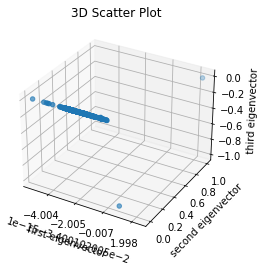

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v1, v2, v3)

# Add labels and title
ax.set_xlabel('first eigenvector')
ax.set_ylabel('second eigenvector')
ax.set_zlabel('third eigenvector')
ax.set_title('3D Scatter Plot')

# Display the plot
plt.show()

In [17]:
laplacian_matrix * v2
el = 7.82882617e-01 /v2[0]
print(el)

-676.1353364707564


3. Sort eigenvalues and eigenvectors: Once you have the eigenvalues and eigenvectors of the Laplacian matrix, you can sort them in ascending order of eigenvalues to identify the most important eigenvectors. Here's an example:

In [24]:
# Sort the eigenvalues in ascending order
sort_index = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sort_index]
eigenvectors = eigenvectors[:, sort_index]

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:")
print(eigenvectors)

Eigenvalues: [-1.08036111e-10  6.76135336e+02  9.99638239e+02  1.46845268e+03
  1.62084878e+03  1.64603282e+03  1.65277951e+03  1.67762752e+03
  1.70500192e+03  1.74146955e+03  1.75207132e+03  1.75875914e+03
  1.80884930e+03  1.84125343e+03  1.87625750e+03  1.91811793e+03
  1.96984208e+03  2.02769079e+03  2.03190796e+03  2.06154650e+03
  2.13555173e+03  2.16351386e+03  2.34642678e+03  2.35011424e+03
  2.35587733e+03  2.43070148e+03  2.44849990e+03  2.52330681e+03
  2.71351450e+03  2.72814308e+03  2.74364482e+03  2.75426974e+03
  2.81736341e+03  2.84649325e+03  2.90712153e+03  2.91690528e+03
  3.38749441e+03  3.40518370e+03  3.43115479e+03  3.52857381e+03
  3.53189696e+03  3.53395723e+03  3.54523743e+03  3.59440768e+03
  3.59811217e+03  3.60825510e+03  3.66113882e+03  3.69793606e+03
  3.77785212e+03  3.83176385e+03  3.87984455e+03  3.92634227e+03
  3.97923084e+03  3.98932159e+03  4.02191508e+03  4.05281155e+03
  4.13406744e+03  4.18616948e+03  4.20616420e+03  4.29915284e+03
  4.30670028

In [ ]:
idx = eigenvalues.argsort()
eigenValues = eigenvalues[idx]
eigenVectors = eigenvectors[:,idx]

# print the sorted eigenvalues and eigenvectors
print("Sorted eigenvalues: ", eigenValues)
print("Sorted eigenvectors: ", eigenVectors)

In [19]:
# Determine the minimum and maximum values of the data
min_val = np.min(eigenVectors)
max_val = np.max(eigenVectors)

print(min_val)
print(max_val)

min_vall = np.min(eigenValues)
max_vall= np.max(eigenValues)

print(min_vall)
print(max_vall)

-0.9993592624899806
0.9992553156636704
-1.0803611090682964e-10
2411069.272206553


## Adjacency Matrix Plot

In [20]:
from scipy.sparse import csr_matrix
import numpy as np

# Convert the graph to a NumPy array
adjacency = nx.to_numpy_array(G)
# Calculate the mean and standard deviation of the csr_matrix
mean = adjacency.mean()
std = np.std(adjacency)

# Print the results
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: 277.43546125831136
Standard deviation: 2112.723846518322


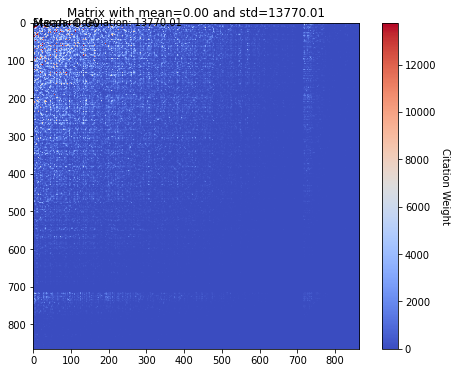

In [ ]:
# Plot the matrix as a heatmap with the mean and standard deviation
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(adjacency, cmap='coolwarm', vmin= mean, vmax=std)
ax.set_title(f"Matrix with mean={mean:.2f} and std={std:.2f}")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Citation Weight", rotation=-90, va="bottom")

# Add the mean and standard deviation to the plot
ax.text(0, -1, f"Mean: {mean:.2f}", fontsize=12, ha="left", va="center")
ax.text(0, -2, f"Standard deviation: {std:.2f}", fontsize=10, ha="left", va="center")

plt.show()

# Simple Laplacian Plot (not normalized)

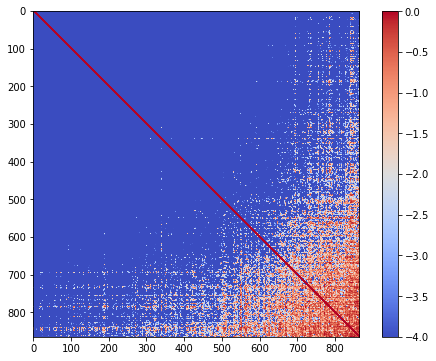

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
mean = laplacian_matrix_array.mean()
std = np.std(laplacian_matrix_array)

im = ax.imshow(laplacian_matrix_array, cmap='coolwarm', vmin=-4, vmax=0.01)
cbar = ax.figure.colorbar(im, ax=ax)

## Degree Matrix Plot (Weighted degrees)

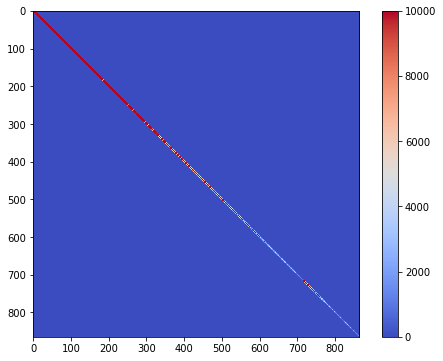

In [ ]:
# Create a 2D array of zeros with the same shape as the adjacency matrix
degree_matrix = np.zeros((len(degrees), len(degrees)))

# Set the diagonal elements of the degree matrix to the corresponding degree values
np.fill_diagonal(degree_matrix, degrees_array)

# Plot the degree matrix as a heatmap
from matplotlib.colors import Normalize

# Normalize the data to the range of 0 to 1
norm = Normalize(vmin=0, vmax=10000)

fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(degree_matrix, cmap='coolwarm', norm=norm)
plt.colorbar()
plt.show()

# Spectral Clustering

In [ ]:
# choosing parameter k
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
# assume X is the data matrix
# assume L is the Laplacian matrix
# assume eigvecs are the eigenvectors of L
# assume eigvals are the eigenvalues of L

# define a range of k values to try
k_values = range(2, 10)

# compute the silhouette score for each value of k
silhouette_scores = []
for k in k_values:
    embedding = eigenvectors[:, :k]
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(embedding)
    sil_score = silhouette_score(embedding, labels)
    silhouette_scores.append(sil_score)

# find the value of k that maximizes the silhouette score
best_k = k_values[np.argmax(silhouette_scores)]

In [ ]:
best_k

2

In [ ]:
from sklearn.cluster import SpectralClustering
# choose the number of dimensions for the embedding
k = 2

# take the k smallest eigenvectors and use them to embed the data
embedding = eigenvectors[:, :k]

# perform spectral clustering with the optimal number of clusters
spectral = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', assign_labels='kmeans')
labels = spectral.fit_predict(embedding)

# print the cluster labels
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0
 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0
 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1
 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1
 0 1 1 0 0 1 1 0 0 0 0 1 

In [ ]:
"""
# count the number of nonzero eigenvalues
num_nonzero_eigenvalues = np.count_nonzero(sorted_eigenvalues)

# count the number of zero eigenvalues
num_zero_eigenvalues = len(sorted_eigenvalues) - num_nonzero_eigenvalues

# print the number of zero eigenvalues
print("Number of zero eigenvalues: ", num_zero_eigenvalues)
print("Number of nonzero eigenvalues: ", num_nonzero_eigenvalues)
"""

Number of zero eigenvalues:  0
Number of nonzero eigenvalues:  3


In [ ]:
"""
num_nonzero_eigenvalues = np.count_nonzero(sorted_eigenvalues)

# count the number of zero eigenvalues
num_zero_eigenvalues = len(sorted_eigenvalues) - num_nonzero_eigenvalues

# print the number of zero eigenvalues
print("Number of zero eigenvalues: ", num_zero_eigenvalues)
"""

Number of zero eigenvalues:  0
